In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from subgoals import SUBGOALS
SUBGOALS = SUBGOALS['small']
import jax
from src import icvf_learner as learner
from src.icvf_networks import icvfs, create_icvf
from flax.serialization import from_state_dict
import numpy as np
import pickle
import matplotlib.animation as animation 
#import html
from IPython.display import HTML


In [2]:
icvf_path = "/home/dashora7/icvf_release/experiment_output/icvf_antmaze/icvf/icvf_multilinear_antmaze-umaze-v2_20231102_114935/params.pkl"
assert icvf_path is not None, "Need to provide path to ICVF model!"    
with open(icvf_path, 'rb') as f:
    icvf_params = pickle.load(f)

params = icvf_params['agent']
conf = icvf_params['config']
value_def = create_icvf('multilinear', hidden_dims=[256, 256])


agent = learner.create_learner(
    seed=42, observations=np.ones((1, 29)),
    value_def=value_def, **conf)
agent = from_state_dict(agent, params)

def icvf_repr_fn(obs):
    return agent.value(obs, method='get_phi')
def icvf_value_fn(obs, goal):
    obs = obs.reshape(1, -1)
    goal = goal.reshape(1, -1)
    return -1 * agent.value(obs, goal, goal).mean()
def icvf_full(obs, outcome, goal):
    obs = obs.reshape(1, -1)
    goal = goal.reshape(1, -1)
    outcome = outcome.reshape(1, -1)
    return -1 * agent.value(obs, outcome, goal).mean()

state_repr_func = jax.jit(icvf_repr_fn)
value_fn = jax.jit(icvf_value_fn)

Extra kwargs: {}


In [24]:
fpath = '/home/dashora7/nitish_dataset_terms.npy'
data = np.load(fpath, allow_pickle=True)
data_dict = data.item()
state_list = data_dict['observations'][996121:996299]
# state_list[:, 2:] = 0

In [25]:
for sg in SUBGOALS:
    # run icvf on subgoal
    sg_repr = np.linalg.norm(state_repr_func(sg) - state_repr_func(SUBGOALS[-1]))
    sg_value = value_fn(sg, SUBGOALS[-1])
    # print(f"Subgoal: {sg}")
    # print(f"Representation: {sg_repr}")
    print(f"Value: {sg_value}", f"Norm: {sg_repr}")

Value: 50.49987030029297 Norm: 38.3673095703125
Value: 49.15460968017578 Norm: 37.55653762817383
Value: 42.800758361816406 Norm: 41.141197204589844
Value: 33.45317077636719 Norm: 37.36104965209961
Value: 22.005290985107422 Norm: 38.9366455078125
Value: 11.832773208618164 Norm: 30.889352798461914
Value: -1.6774953603744507 Norm: 0.0


[0, 1, 33, 70, 96, 123, 158]


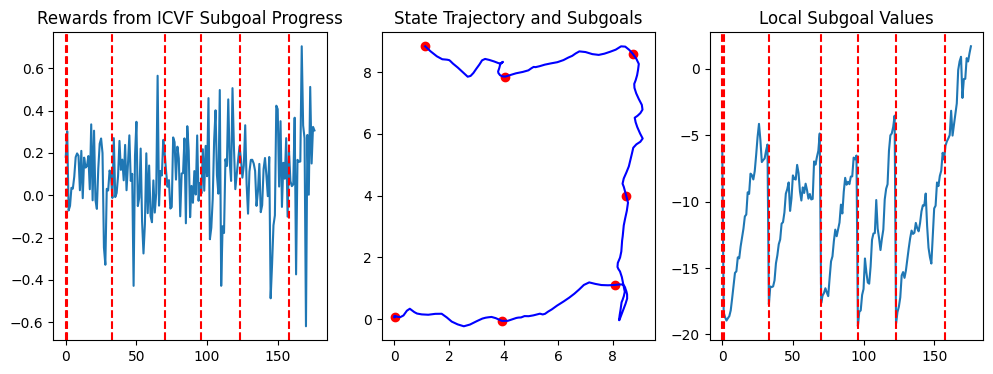

In [32]:
rews = []
idx = 1
sg = SUBGOALS[idx]
eps = 0.5
subgoal_switches = []
vals = []
for i, state in enumerate(state_list[1:]):
    reward = 0
    old_idx = idx
    idx = np.argmin([value_fn(state, sg) for sg in SUBGOALS])
    #idx = np.argmin([np.linalg.norm(state_repr_func(state) - state_repr_func(sg)) for sg in SUBGOALS])
    
    if old_idx != idx:
        subgoal_switches.append(i)
    sg = SUBGOALS[min(idx + 1, len(SUBGOALS) - 1)]
    
    #if np.linalg.norm(state_repr_func(state) - state_repr_func(sg)) <= eps:
    #    reward += 0.2
    if value_fn(state, sg) <= eps:
        reward += 0.2

    val_to_sg = value_fn(state, sg) # negative value
    vals.append(-1 * val_to_sg)
    last_val_to_sg = value_fn(state_list[i], sg) # negative value
    val_diff = np.array(val_to_sg - last_val_to_sg).item()
    reward -= 0.2 * val_diff # * (1 / self.subgoal_dist_factor), progress based, normalized?
    rews.append(reward)

# plot rews
print(subgoal_switches)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].set_title('Rewards from ICVF Subgoal Progress')
axs[1].set_title('State Trajectory and Subgoals')
axs[2].set_title('Local Subgoal Values')
axs[0].plot(rews)
# plot vertical lines at switches
for i in subgoal_switches:
    axs[0].axvline(x=i, color='r', linestyle='--')
# plot states and subgoals in 2nd plot
axs[1].plot(state_list[:, 0], state_list[:, 1], color='b')
axs[1].scatter(SUBGOALS[:, 0], SUBGOALS[:, 1], color='r')
axs[2].plot(vals)
for i in subgoal_switches:
    axs[2].axvline(x=i, color='r', linestyle='--')


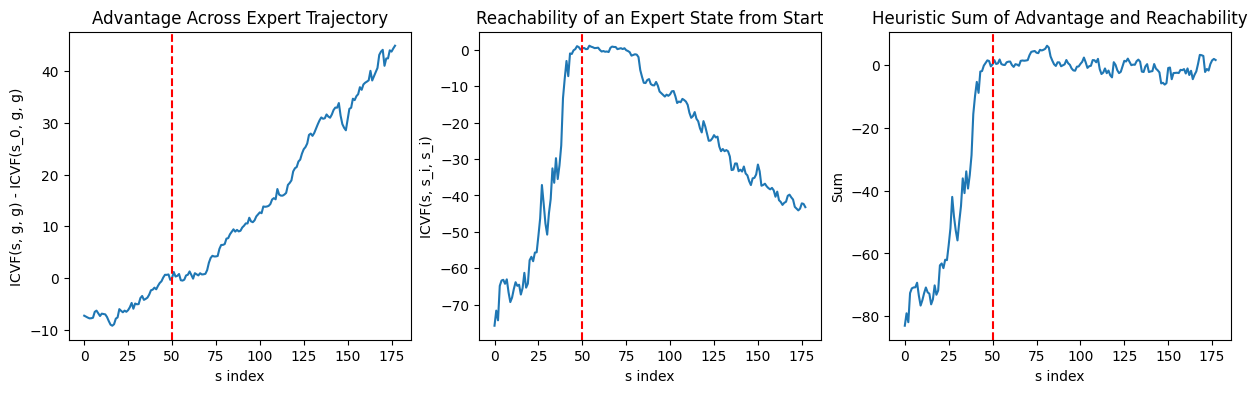

In [56]:
# loop through state list from beginning to end. 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
START_IDX = 50
state_indxs = []
avds  = []
for i, state in enumerate(state_list):
    state_indxs.append(i)
    avds.append(-1 * value_fn(state, SUBGOALS[-1]) +  value_fn(state_list[START_IDX], SUBGOALS[-1]))

scale_adv = (np.array(avds) - avds[START_IDX]) / (avds[-1] - avds[START_IDX] + 1e-8)

axs[0].plot(state_indxs, avds)
axs[0].set_title('Advantage Across Expert Trajectory')
axs[0].set_ylabel('ICVF(s, g, g) - ICVF(s_0, g, g)')
axs[0].set_xlabel('s index')
axs[0].axvline(x=START_IDX, color='r', linestyle='--')

values  = []
for i, state in enumerate(state_list):
    values.append(-1 * value_fn(state_list[START_IDX], state))

scale_values = (np.array(values) - values[START_IDX]) / (values[-1] - values[START_IDX] + 1e-8)

axs[1].plot(state_indxs, values)
axs[1].set_title('Reachability of an Expert State from Start')
axs[1].set_ylabel('ICVF(s, s_i, s_i)')
axs[1].set_xlabel('s index')
axs[1].axvline(x=START_IDX, color='r', linestyle='--')

a, b = 1, 1

def h_test(adv, val):
    #scale_values = (np.array(val) - np.min(values)) / (np.max(values) - np.min(values) + 1e-8)
    scale_values = (np.array(val) - values[START_IDX]) / (values[-1] - values[START_IDX] + 1e-8)
    # scale_adv = (np.array(adv) - np.min(avds)) / (np.max(avds) - np.min(avds) + 1e-8)
    scale_adv = (np.array(adv) - avds[START_IDX]) / (avds[-1] - avds[START_IDX] + 1e-8)
    return a*scale_adv * b*(1 - scale_values)

heuristic  = [(a * adv) + (b * val) for adv, val in zip(avds, values)]
# heuristic = [h_test(adv, val) for adv, val in zip(avds, values)]
axs[2].plot(state_indxs, heuristic)
axs[2].set_title('Heuristic Sum of Advantage and Reachability')
axs[2].set_ylabel('Sum')
axs[2].set_xlabel('s index')
axs[2].axvline(x=START_IDX, color='r', linestyle='--')

# compute subgoal
# TODO: online plot this
plt.show()


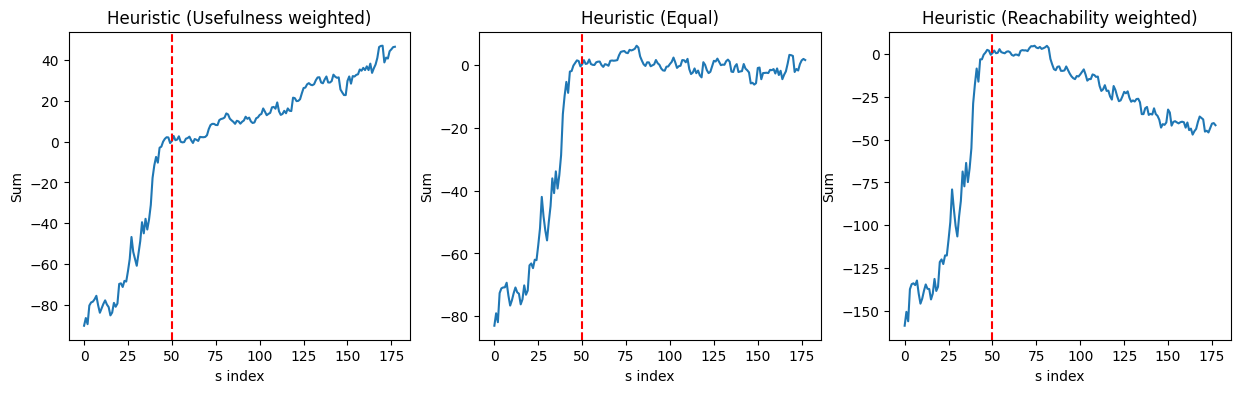

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

a, b = 2, 1
heuristic  = [a * adv + b * val for adv, val in zip(avds, values)]
axs[0].plot(state_indxs, heuristic)
axs[0].set_title('Heuristic (Usefulness weighted)')
axs[0].set_ylabel('Sum')
axs[0].set_xlabel('s index')
axs[0].axvline(x=START_IDX, color='r', linestyle='--')

a, b = 1, 1
heuristic  = [(a * adv) + (b * val) for adv, val in zip(avds, values)]
axs[1].plot(state_indxs, heuristic)
axs[1].set_title('Heuristic (Equal)')
axs[1].set_ylabel('Sum')
axs[1].set_xlabel('s index')
axs[1].axvline(x=START_IDX, color='r', linestyle='--')

a, b = 1, 2
heuristic  = [a * adv + b * val for adv, val in zip(avds, values)]
axs[2].plot(state_indxs, heuristic)
axs[2].set_title('Heuristic (Reachability weighted)')
axs[2].set_ylabel('Sum')
axs[2].set_xlabel('s index')
axs[2].axvline(x=START_IDX, color='r', linestyle='--')

plt.show()

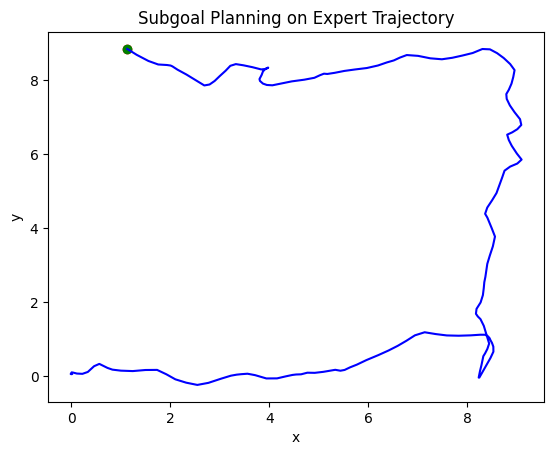

In [30]:
a, b = 1, 1.1
fig, ax = plt.subplots()
ax.set_title('Subgoal Planning on Expert Trajectory')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(state_list[:, 0], state_list[:, 1], color='b')
scat = ax.scatter(state_list[0, 0], state_list[0, 1], color='r')
abc = None
def animate(i):
    global abc
    scat.set_offsets(state_list[i, :2])
    
    values  = []
    for j, state in enumerate(state_list):
        values.append(-1 * value_fn(state_list[i], state))
    avds = []
    for j, state in enumerate(state_list):
        state_indxs.append(j)
        avds.append(-1 * value_fn(state, SUBGOALS[-1]) +  value_fn(state_list[i], SUBGOALS[-1]))
    
    
    heuristic  = [a * adv + b * val for adv, val in zip(avds, values)]
    # get max and plot it
    max_idx = np.argmax(heuristic)
    if abc is not None:
        abc.set_visible(False)
    abc = ax.scatter(state_list[max_idx, 0], state_list[max_idx, 1], color='g')
    return scat,

anim = animation.FuncAnimation(fig, animate, frames=len(state_list), interval=200, blit=True)


HTML(anim.to_html5_video())
